# Classification Model section

In [6]:
#load model resnet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import kagglehub

E0000 00:00:1732525838.385576  163303 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732525838.387637  163303 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/sugeng/miniconda3/envs/yolo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:

path = kagglehub.dataset_download("swoyam2609/fresh-and-stale-classification")

print("Path to dataset files:", path)

In [ ]:
# pred single image
with tf.device('/cpu:0'):
    new_model = tf.keras.models.load_model('cabbage.keras')
    four_class_labels = ['freshcabbage', 'freshapples', 'freshbanana', 'freshcapsicum',   'freshtomato', 'rottencabbage','rottenapples', 'rottenbanana', 'rottencapsicum',  'rottentomato']
    Freshness = ['Fresh', 'Rotten']
    img_path = '/home/sugeng/Downloads/test3.jpg'
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = new_model.predict(img_array)
for i, lbl in enumerate(Freshness):
    print(f'{lbl}: {predictions[0][i]:.4f}')


In [ ]:
plt.imshow(img)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


test_ds = image_dataset_from_directory(
    path+'/dataset/Test',
    label_mode='categorical',
    color_mode='rgb',
    seed=1337,
    image_size=(224, 224),
    batch_size=32,
)

print(test_ds.class_names)

test_label = test_ds.class_names

In [ ]:
# Evaluate per label manually 
y_pred = []
y_true = []
for images, labels in test_ds:
    predictions = new_model.predict(images)
    for i, label in enumerate(labels):
        y_true.append(np.argmax(label))
        y_pred.append(np.argmax(predictions[i][[1, 2, 4, 6, 7, 9]]))
        
cm = confusion_matrix(y_true, y_pred)

        
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_label, yticklabels=test_label)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Overall acc, f1, precision, recall
print(classification_report(y_true, y_pred, target_names=test_label))

# Object detection section

In [1]:
from ultralytics import YOLO
img_path = "/home/sugeng/Downloads/freshcapsicum.png"
model = YOLO("fruits-and-vegetables-17y0t/yolov11l/weights/best.pt")
res = model.predict(img_path,device='cpu')
res[0].summary()[0]



image 1/1 /home/sugeng/Downloads/freshcapsicum.png: 640x480 1 capsicum, 1 tomato, 106.5ms
Speed: 1.0ms preprocess, 106.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


{'name': 'capsicum',
 'class': 3,
 'confidence': 0.58923,
 'box': {'x1': 21.02034, 'y1': 23.69895, 'x2': 358.23199, 'y2': 473.3476}}

In [76]:
model.names

{0: 'apple', 1: 'banana', 2: 'cabbage', 3: 'capsicum', 4: 'tomato'}

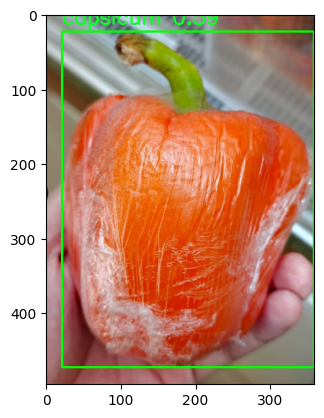

In [2]:
# Draw the bounding box
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread(img_path)
x1 , y1, x2, y2=res[0].summary()[0]['box'].values()
cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
cv2.putText(img, f"{model.names[int(res[0].summary()[0]['class'])]} {res[0].summary()[0]['confidence']:.2f}", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
# Crop the image
img = cv2.imread(img_path)
crop_img = img[int(y1):int(y2), int(x1):int(x2)]
plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))

### With image classification

In [7]:
def fruitModel(img: np.ndarray, label: str) -> tf.keras.models.Model:
    print(label)
    with tf.device('/cpu:0'):
        if label == 'apple':
            new_model = tf.keras.models.load_model('apple.keras')
        elif label == 'banana':
            new_model = tf.keras.models.load_model('banana.keras')
        elif label == 'capsicum':
            new_model = tf.keras.models.load_model('capsicum.keras')
        elif label == 'tomato':
            new_model = tf.keras.models.load_model('tomato.keras')
        elif label == 'cabbage':
            new_model = tf.keras.models.load_model('cabbage.keras')
        else:
            return 'No model found'
        img_array = cv2.resize(img, (224, 224))
        img_array = np.expand_dims(img_array, axis=0)
        predictions = new_model.predict(img_array)
        return predictions

In [8]:
predictions = fruitModel(img, model.names[int(res[0].summary()[0]['class'])])

capsicum
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


In [9]:
Freshness = ['Fresh', 'Rotten']
for i, lbl in enumerate(Freshness):
    print(f'{lbl}: {predictions[0][i]:.4f}')

Fresh: 0.0000
Rotten: 1.0000


In [41]:
#Reset GPU memory (always do this after training)
from numba import cuda 
device = cuda.get_current_device()
device.reset()

CudaSupportError: Error at driver init: 
Call to cuInit results in CUDA_ERROR_NO_DEVICE (100):